In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill 
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

In [4]:
pID = '11'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 1s
data_eeg_name = '\data_s11_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name = '\data_s11_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name = '\data_s11_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg = pd.read_csv(path+pID+data_eeg_name)
data_emg = pd.read_csv(path+pID+data_emg_name)
data_emg.iloc[:,3] = data_emg.iloc[:,3] - np.mean(data_emg.iloc[:len(data_emg)//2,3])
data_emg.iloc[:,4] = data_emg.iloc[:,4] - np.mean(data_emg.iloc[:len(data_emg),4])
data_emg.rename(columns={'EMG1':'Deltoid', 'EMG2':'Biceps'}, inplace=True )
data_eye = pd.read_csv(path+pID+data_eye_name)


In [5]:
fs = 250

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

# EMG Window 
win_emg = 250
win_emg_scaled = np.arange(len(data_emg))//win_emg

# EYE Window 
win_eye = 100
win_eye_scaled = np.arange(len(data_eye))//win_eye

<font size="4">    <b>Epoch representation, Highlight when the 2 classes are significatively differents ??</b>

In [6]:
#Find the RP treshold
data_wilk_x = data_eeg.iloc[:len(data_eeg)//2,:]
data_wilk_y = data_eeg.iloc[(len(data_eeg)//2):,:]

wilk_x = np.zeros((fs, len(data_wilk_x)//250))
wilk_y = np.zeros((fs, len(data_wilk_x)//250))

for j in range(fs):
    for i in range(wilk_x.shape[1]):
        wilk_x[j, i] = data_wilk_x['FCz'].values[(i*250)+j]
        wilk_y[j, i] = data_wilk_y['FCz'].values[(i*250)+j]
        
thresh = 0
t_ind_eeg = []
for i in range(1,fs):
    w, p = wilcoxon(wilk_x[i, :], wilk_y[i, :])
    
    if p < 0.05:
        thresh += 1
    else:
        thresh = 0
    if thresh > 3:
        t_ind_eeg.append(i)

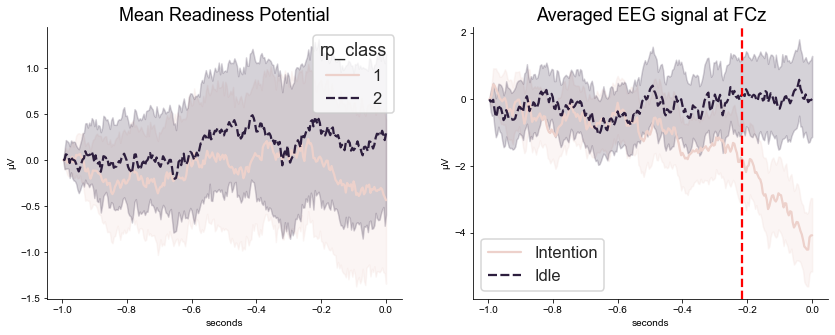

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrodes = data_eeg.iloc[:,3:].mean(axis=1)
electrode = 'FCz'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=data_eeg)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data_eeg, legend=True)
g2.set(xlabel='seconds', ylabel='\u03bcV', title='Averaged EEG signal at ' + electrode)

# Detection onset
plt.axvline(data_eeg['sample'].values[min(t_ind_eeg)],
            color='red', label = None, linestyle ='--')

# legend
leg = g2.legend_
new_title = 'Class'
leg.set_title(new_title)
plt.legend(loc='lower left')
# replace labels
new_labels = ['Intention', 'Idle']
for t, l in zip(g2.legend_.texts, new_labels):
    t.set_text(l)

In [8]:
data_eeg['sample'].values[min(t_ind_eeg)]

-0.216

In [14]:
#Find the Delto treshold
data_wil_x = data_emg.iloc[:len(data_eeg)//2,:]
data_wil_y = data_emg.iloc[(len(data_eeg)//2):,:]

wil_x = np.zeros((fs, len(data_wil_x)//250))
wil_y = np.zeros((fs, len(data_wil_x)//250))

for j in range(fs):
    for i in range(wil_x.shape[1]):
        wil_x[j, i] = data_wil_x['Deltoid'].values[(i*250)+j]
        wil_y[j, i] = data_wil_y['Deltoid'].values[(i*250)+j]
        
thresh = 0
t_ind_del = []
for i in range(1,fs):
    w, p = wilcoxon(wil_x[i, :], wil_y[i, :])
    
    if p < 0.05:
        thresh += 1
    else:
        thresh = 0
    if thresh > 3:
        t_ind_del.append(i)

In [16]:
t_ind_del

[196,
 197,
 203,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249]

In [11]:
#Find the Biceps treshold
data_wik_x = data_emg.iloc[:len(data_eeg)//2,:]
data_wik_y = data_emg.iloc[(len(data_eeg)//2):,:]

wik_x = np.zeros((fs, len(data_wik_x)//250))
wik_y = np.zeros((fs, len(data_wik_x)//250))

for j in range(fs):
    for i in range(wik_x.shape[1]):
        wik_x[j, i] = data_wik_x['Biceps'].values[(i*250)+j]
        wik_y[j, i] = data_wik_y['Biceps'].values[(i*250)+j]
        
thresh = 0
t_ind_bic = []
for i in range(1,fs):
    w, p = wilcoxon(wik_x[i, :], wik_y[i, :])
    
    if p < 0.05:
        thresh += 1
    else:
        thresh = 0
    if thresh > 3:
        t_ind_bic.append(i)

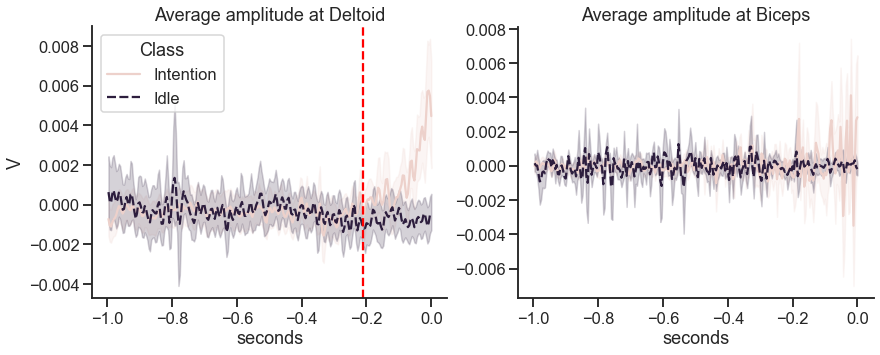

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")


electrode1 = 'Deltoid'
electrode2 = 'Biceps'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrode1,
             hue="rp_class", style="rp_class",
             data=data_emg)
sns.despine()
g.set(xlabel='seconds', ylabel='V', title='Average amplitude at '+ electrode1)
# Detection onset
axes[0].axvline(data_emg['sample'].values[min(t_ind_del)],
            color='red', label = 'Threshold', linestyle ='--')

# Detection onset
#plt.axvline(data_emg['sample'].values[min(t_ind_bic)],
#            color='red', label = 'Threshold', linestyle ='--')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode2,
             hue="rp_class", style="rp_class",
             data=data_emg, legend=False)
g2.set(xlabel='seconds', ylabel=None, title='Average amplitude at '+ electrode2)


# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['Intention', 'Idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

In [20]:
data_emg['sample'].values[min(t_ind_del)]

-0.216

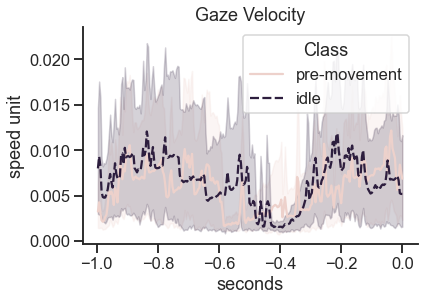

In [6]:
sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y='GazeVel',
             hue="rp_class", style="rp_class",
             data=data_eye)
sns.despine()
g.set(xlabel='seconds', ylabel='speed unit', title='Gaze Velocity')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

<font size="4">    <b>Clean feature definitions</b>

In [5]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

<font size="4">    <b>Not clean feature extraction</b>

In [6]:
#Waveform length
wl_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
b = np.zeros((win_emg))
wl_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))
c = np.zeros((win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    wl_1[j] = np.sum(b)
    wl_2[j] = np.sum(c)
    
    for i in range(win_emg):
        b[i] = abs(data_emg['Biceps'][(i+1)+j] - data_emg['Biceps'][i+j])
        c[i] = abs(data_emg['Deltoïd'][(i+1)+j] - data_emg['Deltoïd'][i+j])
        
#Mean absolute value slope
d_1 = data_emg.groupby(win_emg_scaled)['Biceps'].apply(mav)
mavs_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
d_2 = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(mav)
mavs_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))

for i in range((len(data_emg['Biceps'])//win_emg)-1):
    mavs_1[i] = d_1[i+1] - d_1[i]
    mavs_2[i] = d_2[i+1] - d_2[i]   

In [7]:
#Zero crossing
z_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
z_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(win_emg):
        if data_emg['Biceps'][i+j] > 0 and data_emg['Biceps'][(i+1)+j] < 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        elif data_emg['Biceps'][i+j] < 0 and data_emg['Biceps'][(i+1)+j] > 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        else:
            z_1[j] += 0

        if data_emg['Deltoïd'][i+j]>0 and data_emg['Deltoïd'][(i+1)+j]<0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        elif data_emg['Deltoïd'][i+j]<0 and data_emg['Deltoïd'][(i+1)+j]>0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        else:
            z_2[j] += 0

In [8]:
#Slope sign change
ss_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
ss_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(1,win_emg):
        if data_emg['Biceps'][i+j] > data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] > data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        elif data_emg['Biceps'][i+j] < data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] < data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        else:
            ss_1 += 0
        
        if data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        elif data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        else:
            ss_2 += 0

<font size="4">    <b>Feature extraction</b>
    
EEG: We want to extract 1 feature (mean) at each window having a size of 25 samples, so 10 times per epoch or per second.
    
    -> 10 features per epoch per channel.

EMG: We want to extract X features (5 ? See if selection) at each window having a size of 100 samples, so 10 times per epoch or per seconds.
    
    ->10 features per epoch per channel (better do features on win_size 25 ? so 40 features per epoch per channel).

In [9]:
# Write the features list we want to use for the EMG data.
feat_list = [rms, mini, maxi, mav, var]                                        #list for apply groupby
nfeat_list = ['rms', 'mini', 'maxi', 'mav', 'var']  #, 'wl'#  'mavs', 'zc', 'ssc'    accessory

muscle_1 =[None] * len(feat_list)
muscle_2 =[None] * len(feat_list)

# Exctract the features at each window size for each channel for each epoch and put them in a DataFrame

#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

#EMG 2nd DataFrame
for i in range(len(feat_list)):
    muscle_1[i] = data_emg.groupby(win_emg_scaled)['Biceps'].apply(feat_list[i])
    muscle_2[i] = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(feat_list[i])

#muscle_1.append(wl_1) 
#muscle_2.append(wl_2)
#muscle_1.append(mavs_1) 
#muscle_2.append(mavs_2)
#muscle_1.append(z_1) 
#muscle_2.append(z_2)
#muscle_1.append(ss_1) 
#muscle_2.append(ss_2)

m1 = pd.DataFrame(muscle_1, index=nfeat_list).transpose()
m2 = pd.DataFrame(muscle_2, index=nfeat_list).transpose()
mk = {'Biceps':m1, 'Deltoïd':m2}
muscles = pd.concat([m1,m2], axis=1, keys=mk.keys())
c_labels = data_emg.iloc[:,:3].groupby(win_emg_scaled).mean() # Labels for the EMG DataFrame

win_emg_mean = pd.concat([c_labels, muscles], axis=1)

In [24]:
win_eeg_mean

,sample,epoch_ix,rp_class,FC1,C2,Cz,TP9,FCz,Fp2,CP5,...,C3,C4,F4,AF4,TP10,P5,PO3,F6,CP2,PO7
0,-0.948,1.0,1.0,9.477373,6.873381,7.893376,-4.606621,9.061377,-5.250618,-1.466639,...,2.949366,3.913375,6.781375,-1.338626,-10.690623,-1.590615,-0.906615,3.321381,2.465372,-1.810616
1,-0.848,1.0,1.0,14.187434,6.775443,13.611439,-8.460559,14.779439,-7.684553,-2.864580,...,5.679430,4.707435,5.979437,-1.552565,-11.720560,-3.644553,-4.416553,-1.600557,0.443433,-6.044554
2,-0.748,1.0,1.0,13.357246,6.345255,12.949251,-1.394745,13.913251,-12.662743,5.325234,...,7.481242,4.301249,2.809250,-5.786753,-13.790747,4.909259,0.385260,-1.718746,1.173244,0.829258
3,-0.648,1.0,1.0,5.699996,8.620007,9.156002,-1.659995,10.388004,-17.335990,-1.184015,...,-2.784007,10.120000,1.300000,-10.540000,-4.587997,4.900009,11.124010,1.360008,6.635998,9.024009
4,-0.548,1.0,1.0,12.605622,13.533632,16.917627,-6.738370,18.033629,-25.058367,1.465607,...,2.497614,12.305622,2.541626,-11.162375,-8.270373,3.913635,5.597635,-2.962368,8.909620,2.197634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,-0.448,270.0,2.0,0.659502,5.955504,3.163504,14.427501,3.067499,-16.712497,5.111499,...,7.075500,-0.968503,-1.164497,-7.420501,10.531500,0.303505,7.535499,-4.016499,7.599502,-3.924500
2696,-0.348,270.0,2.0,1.713001,8.745006,6.997001,14.737002,6.705002,-13.758996,5.029001,...,7.336999,-2.435004,2.753002,-0.730998,10.904999,0.245004,6.313000,-5.494997,9.277001,-6.538999
2697,-0.248,270.0,2.0,-1.164873,15.663128,9.135128,3.023125,9.031124,4.407130,-4.620877,...,-0.056876,7.563121,15.543127,12.299124,14.235123,-6.880872,3.383124,20.999124,12.307127,-14.468875
2698,-0.148,270.0,2.0,-8.650372,16.185625,6.409627,4.045623,6.021621,8.485626,-9.742379,...,-5.894375,12.345621,17.065626,14.225621,30.637623,-6.994371,7.473622,33.449622,15.201627,-11.346375


<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [10]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)

#EMG
df_emg = win_emg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_emg_mean.columns[3:].tolist())
df_emg.reset_index(inplace=True)

#EEG - EMG
df_eeg_emg = pd.concat([df_eeg, df_emg.iloc[:,2:]], axis=1)

In [25]:
df_eeg

epoch_ix rp_class       FC1                                   \
sample                      -0.948     -0.848     -0.748     -0.648   
0           1.0      1.0  9.477373  14.187434  13.357246   5.699996   
1           2.0      1.0  0.042750   0.540687  -0.504937  -0.817000   
2           3.0      1.0  6.279313   6.024813  10.481875   7.951375   
3           4.0      1.0 -0.022813   0.364438   1.166437   1.034875   
4           5.0      1.0 -1.344625   3.971187   6.842563  10.908250   
..          ...      ...       ...        ...        ...        ...   
265       266.0      2.0  0.475371   1.184184   0.899558   0.169246   
266       267.0      2.0  0.111690 -10.002935 -14.116435 -13.652623   
267       268.0      2.0  1.817819   5.422255   3.409632   0.423381   
268       269.0      2.0 -3.075497   1.317564  -2.062684   0.129379   
269       270.0      2.0  1.480376  -1.637936   1.374815  -0.571311   

                                                                       ...  \
sample -0.5479999999999999 -0.44799999999999995     -0.348     -0.248  ...   
0                12.605622            10.260058  11.957622  18.400870  ...   
1                -0.892000            -1.563189   0.914125   1.814625  ...   
2                 8.792750             4.926938   6.289750   4.226000  ...   
3                 2.276812             5.297000  -5.985438  -8.373813  ...   
4                 6.078376            10.502750   3.416688  -8.667063  ...   
..                     ...                  ...        ...        ...  ...   
265               3.227620            -1.442817  -7.727629  -7.288379  ...   
266             -15.710436           -12.744747 -19.014873 -17.710998  ...   
267               0.085944             0.899506   1.894568   5.519631  ...   
268              -3.978434            -4.451997  -2.278685   2.102502  ...   
269               3.910690             0.659502   1.713001  -1.164873  ...   

             PO7                                                    \
sample    -0.948    -0.848    -0.748    -0.648 -0.5479999999999999   
0      -1.810616 -6.044554  0.829258  9.024009            2.197634   
1       3.946755  3.192693 -0.224933  0.423005            1.196006   
2       4.047314  5.488814  6.853875 -2.264624           -3.131249   
3       4.845188  8.068437  7.774437  8.974875            6.900813   
4       4.455375  3.239187 -0.337437  0.976250            0.098376   
..           ...       ...       ...       ...                 ...   
265    -0.288629 -6.511815 -2.216441 -2.638754           -1.208378   
266     3.511693 -0.558933  1.003567  3.295380            3.273568   
267     0.921816 -0.525746  1.345632  5.731380            6.493943   
268     4.680503 -9.634435 -1.270686 -0.254623            8.541565   
269     0.872375  5.974061  0.210813  2.252685           -6.789311   

                                                                       \
sample -0.44799999999999995    -0.348     -0.248 -0.14800000000000002   
0                 -3.575927  0.277635  -3.579116            -3.846366   
1                  2.080818  8.826131  15.622631            16.674568   
2                 -1.917061 -1.386248  -8.205999            -1.003999   
3                  2.945000 -2.661437   0.206187             3.727564   
4                  1.590750  9.312687   2.780937             6.044125   
..                      ...       ...        ...                  ...   
265               -5.986816 -2.447628  -2.652379            -6.390128   
266                1.247255  6.217130   6.009006            -5.453183   
267                6.763505  6.678568   8.575630             4.175566   
268               12.076003  5.517314   5.466502            10.127752   
269               -3.924500 -6.538999 -14.468875           -11.346375   

                   
sample     -0.048  
0       -2.259616  
1        9.554193  
2        4.017251  
3        5.394437  
4        5.925000  
..            ...  
265     -6.982316  
266     -9.350557  
267    

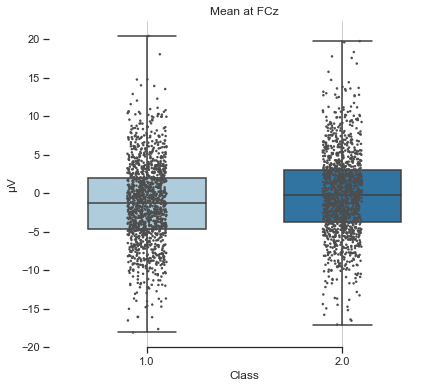

In [203]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = 'rp_class'
val_var = 'FCz'

F1 = sns.boxplot(x=group_var, y=val_var, data=win_eeg_mean,
              whis=[0, 100], width=.6, palette='Paired')
F1.set(title='Mean at '+ val_var)

    # Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=win_eeg_mean,
              size=2.5, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='\u03bcV', xlabel='Class')
sns.despine(trim=True, left=True)

In [46]:
df_eeg

epoch_ix rp_class       FC1                                   \
sample                      -0.948     -0.848     -0.748     -0.648   
0           1.0      1.0  9.477373  14.187434  13.357246   5.699996   
1           2.0      1.0  0.042750   0.540687  -0.504937  -0.817000   
2           3.0      1.0  6.279313   6.024813  10.481875   7.951375   
3           4.0      1.0 -0.022813   0.364438   1.166437   1.034875   
4           5.0      1.0 -1.344625   3.971187   6.842563  10.908250   
..          ...      ...       ...        ...        ...        ...   
265       266.0      2.0  0.475371   1.184184   0.899558   0.169246   
266       267.0      2.0  0.111690 -10.002935 -14.116435 -13.652623   
267       268.0      2.0  1.817819   5.422255   3.409632   0.423381   
268       269.0      2.0 -3.075497   1.317564  -2.062684   0.129379   
269       270.0      2.0  1.480376  -1.637936   1.374815  -0.571311   

                                                                       ...  \
sample -0.5479999999999999 -0.44799999999999995     -0.348     -0.248  ...   
0                12.605622            10.260058  11.957622  18.400870  ...   
1                -0.892000            -1.563189   0.914125   1.814625  ...   
2                 8.792750             4.926938   6.289750   4.226000  ...   
3                 2.276812             5.297000  -5.985438  -8.373813  ...   
4                 6.078376            10.502750   3.416688  -8.667063  ...   
..                     ...                  ...        ...        ...  ...   
265               3.227620            -1.442817  -7.727629  -7.288379  ...   
266             -15.710436           -12.744747 -19.014873 -17.710998  ...   
267               0.085944             0.899506   1.894568   5.519631  ...   
268              -3.978434            -4.451997  -2.278685   2.102502  ...   
269               3.910690             0.659502   1.713001  -1.164873  ...   

             PO7                                                    \
sample    -0.948    -0.848    -0.748    -0.648 -0.5479999999999999   
0      -1.810616 -6.044554  0.829258  9.024009            2.197634   
1       3.946755  3.192693 -0.224933  0.423005            1.196006   
2       4.047314  5.488814  6.853875 -2.264624           -3.131249   
3       4.845188  8.068437  7.774437  8.974875            6.900813   
4       4.455375  3.239187 -0.337437  0.976250            0.098376   
..           ...       ...       ...       ...                 ...   
265    -0.288629 -6.511815 -2.216441 -2.638754           -1.208378   
266     3.511693 -0.558933  1.003567  3.295380            3.273568   
267     0.921816 -0.525746  1.345632  5.731380            6.493943   
268     4.680503 -9.634435 -1.270686 -0.254623            8.541565   
269     0.872375  5.974061  0.210813  2.252685           -6.789311   

                                                                       \
sample -0.44799999999999995    -0.348     -0.248 -0.14800000000000002   
0                 -3.575927  0.277635  -3.579116            -3.846366   
1                  2.080818  8.826131  15.622631            16.674568   
2                 -1.917061 -1.386248  -8.205999            -1.003999   
3                  2.945000 -2.661437   0.206187             3.727564   
4                  1.590750  9.312687   2.780937             6.044125   
..                      ...       ...        ...                  ...   
265               -5.986816 -2.447628  -2.652379            -6.390128   
266                1.247255  6.217130   6.009006            -5.453183   
267                6.763505  6.678568   8.575630             4.175566   
268               12.076003  5.517314   5.466502            10.127752   
269               -3.924500 -6.538999 -14.468875           -11.346375   

                   
sample     -0.048  
0       -2.259616  
1        9.554193  
2        4.017251  
3        5.394437  
4        5.925000  
..            ...  
265     -6.982316  
266     -9.350557  
267    

<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [12]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.6555555555555557
0.05749694331948157


In [20]:
clf_emg.classes_

array([1., 2.])

<font size="3">    <b>EMG</b>

In [13]:
Xemg = df_emg.iloc[:,2:].values
yemg = np.asarray(df_emg['rp_class'])

clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_emg = cross_val_predict(clf_emg, Xemg, yemg, cv=kfolds)

0.8111111111111111
0.111665284679121


<font size="3">    <b>EEG - EMG</b>

In [14]:
X_eeg_emg = df_eeg_emg.iloc[:,2:].values
y_eeg_emg = np.asarray(df_emg['rp_class'])

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(X_eeg_emg, y_eeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg_emg = cross_val_predict(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)

0.8
0.06869347033700521


<font size="3">    <b>Classification metrics - EEG</b>

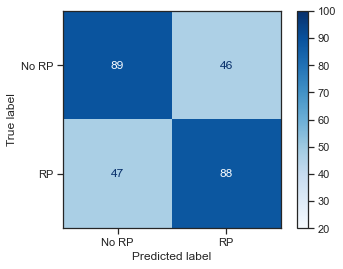

              precision    recall  f1-score   support

       No RP       0.65      0.66      0.66       135
          RP       0.66      0.65      0.65       135

    accuracy                           0.66       270
   macro avg       0.66      0.66      0.66       270
weighted avg       0.66      0.66      0.66       270



In [18]:
cm_eeg = confusion_matrix(y_true=yeeg, y_pred=pred_y_eeg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=yeeg, 
                                y_pred=pred_y_eeg, 
                                target_names=["No RP", "RP"]))

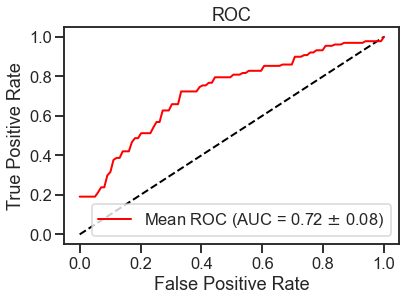

In [218]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xeeg,yeeg):
    prediction = clf_eeg.fit(Xeeg[train],yeeg[train]).predict_proba(Xeeg[test])
    fpr, tpr, t = roc_curve(yeeg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EMG</b>

              precision    recall  f1-score   support

       No RP       0.95      0.66      0.78       135
          RP       0.74      0.96      0.84       135

    accuracy                           0.81       270
   macro avg       0.84      0.81      0.81       270
weighted avg       0.84      0.81      0.81       270



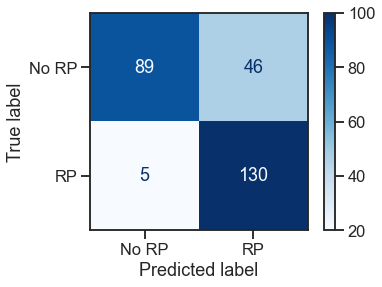

In [227]:
cm_emg = confusion_matrix(y_true=yemg, y_pred=pred_y_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
print(classification_report(y_true=yemg, 
                                y_pred=pred_y_emg, 
                                target_names=["No RP", "RP"]))

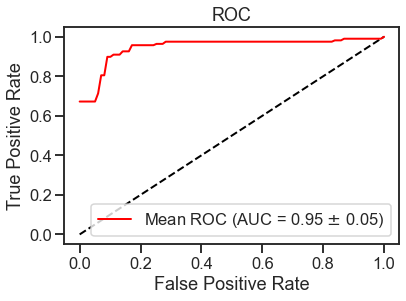

In [263]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xemg,yemg):
    prediction = clf_emg.fit(Xemg[train],yemg[train]).predict_proba(Xemg[test])
    fpr, tpr, t = roc_curve(yemg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EEG-EMG</b>

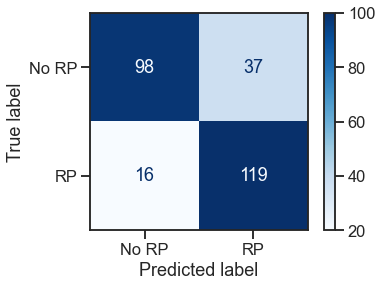

              precision    recall  f1-score   support

       No RP       0.86      0.73      0.79       135
          RP       0.76      0.88      0.82       135

    accuracy                           0.80       270
   macro avg       0.81      0.80      0.80       270
weighted avg       0.81      0.80      0.80       270



In [228]:
cm_eeg_emg = confusion_matrix(y_true=y_eeg_emg, y_pred=pred_y_eeg_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=y_eeg_emg, 
                                y_pred=pred_y_eeg_emg, 
                                target_names=["No RP", "RP"]))

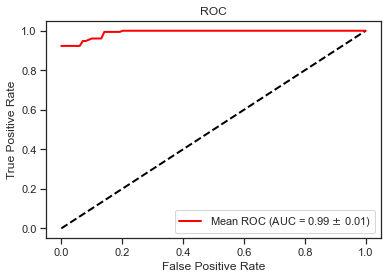

In [23]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(X_eeg_emg,y_eeg_emg):
    prediction = clf_eeg_emg.fit(X_eeg_emg[train],y_eeg_emg[train]).predict_proba(X_eeg_emg[test])
    fpr, tpr, t = roc_curve(y_eeg_emg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3" color='red'>    <b>Load the data and keep 20 best EEG</b>

In [15]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None) # , dtype='float16'
velocity = pd.read_csv(pathm, header=None) # , dtype='float16'

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

In [55]:
np.save('eeg_11', eeg, allow_pickle=True)
np.save('velocity_11', velocity, allow_pickle=True)
np.save('emg_11', emg, allow_pickle=True)

<font size="3" color='Black'>    <b>UNTIL THE FIGURE, THAT'S JUST ANOTHER TRY</b>

In [81]:
# Each sample will have it's value corrected by the value of the 250th sample before it.

#onset_cor = 6000
#f_cor = 250
#onset = move[:-1]
#
#for k in range(len(onset)):
    
#    for i in range(onset_cor + 1000):

#        eeg_a.iloc[:, onset[k] - onset_cor+i] = eeg_b.iloc[:, (onset[k] - onset_cor+i)] - eeg_b.iloc[:, (onset[k] - onset_cor+i) - 250]


In [82]:
#Extract RP class

# Number of sample before and after movement onset
#RPb_onset = 1000
#RPa_onset = 0
#onset = move[:-1] # Adjust according to the number of onset we want to consider

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
#RP_class = np.zeros((len(onset), (RPb_onset + RPa_onset), eeg_b.shape[0]))

#for k in range(len(onset)):
   
#    for j in range(eeg_b.shape[0]):
    
#        RP_class[k, 0:(RPb_onset + RPa_onset), j] = eeg_a.iloc[j, onset[k]-RPb_onset:onset[k]+RPa_onset]

In [83]:
#Extract Idle class

# Number of sample before and after movement onset
#idleb_onset = 6000
#idlea_onset = -5000
#nset = move[:-1] # Adjust according to the number of onset we want to consider

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
#idle_class = np.zeros((len(onset), (idleb_onset + idlea_onset), eeg_b.shape[0]))

#for k in range(len(onset)):
   
#    for j in range(eeg_b.shape[0]):
    
#        idle_class[k, 0:(idleb_onset + idlea_onset), j] = eeg_a.iloc[j, onset[k]-idleb_onset:onset[k]+idlea_onset]

In [84]:
# Feature extraction
#fs = 250
#feat_size = 25
#nb_feat = fs//feat_size

#X = np.zeros((len(onset)*2, (nb_feat)*eeg_b.shape[0]))

#for k in range(len(onset)):
#    for j in range(epoch_cor.shape[2]):
#        for i in range(nb_feat):
        
#            X[k, i + nb_feat*j] = np.mean(RP_class[k, (25*i):25+(25*i), j])
#            X[k+len(onset),i + nb_feat*j] = np.mean(idle_class[k, (25*i):25+(25*i), j])

In [85]:
#X.shape

(298, 200)

In [86]:
#y = np.zeros(len(onset)*2)
#y[len(onset):] = 1

In [87]:
#clf_eeg_2 = LDA(solver='lsqr', shrinkage='auto')

#clf_eeg_2.fit(X, y)

# splits data randomly in n=folds 
#kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

#cv_results = cross_val_score(clf_eeg_2, X, y, cv=kfolds)
#cv_average = cv_results.mean()
#st_deviation = cv_results.std()
#print(cv_average)
#print(st_deviation)

0.4962068965517242
0.1073160105468833


In [88]:
# Number of sample before and after movement onset
#b_onset = 2000
#a_onset = 1000

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
#epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

#for k in range(len(onset)):
   
#    for j in range(eeg_b.shape[0]):
    
#        epoch[k, 0:(b_onset + a_onset), j] = eeg_a.iloc[j, onset[k]-b_onset:onset[k]+a_onset]

In [89]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

#fs = 250             # 250 Here
#nb_feat = fs//win_eeg
#sld_size = 1

#feat = np.zeros((len(epoch), nb_feat*epoch.shape[2], (epoch.shape[1]//sld_size) - fs + sld_size))

#for k in range(len(epoch)):             # Onset index
#    for l in range(feat.shape[2]):          # Window index
#        for j in range(epoch.shape[2]): # Channel index
#            for i in range(nb_feat):        # Feature index
#                feat[k, i+(nb_feat)*j, l] = np.mean(epoch[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

In [93]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

#proba_2 = np.zeros((feat.shape[0], feat.shape[2]))

#for k in range(len(epoch_cor)):
    
#    for l in range(feat.shape[2]):
        
#        proba_2[k, l] = clf_eeg_2.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

In [94]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
#time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
#m_time = np.tile(time, (1, len(epoch_cor))).transpose()
#f_time = np.reshape(m_time, len(m_time))

#f_proba_2 = np.reshape(proba_2, len(f_time))

#m_velocity = actual_velocity[:, :proba_2.shape[1]]
#f_velocity = np.reshape(m_velocity, len(f_time))

#f_data_2 = np.zeros((len(f_time), 3))
#f_data_2[:,0] = f_time
#f_data_2[:,1] = f_velocity * 1000
#f_data_2[:,2] = f_proba_2
#final_2 = pd.DataFrame(f_data_2, columns=['Time', 'Velocity', 'Probability'])
#final_2

,Time,Velocity,Probability
0,-2.000,0.007374,2.613487e-25
1,-1.999,0.006945,5.829473e-28
2,-1.998,0.006947,2.433387e-33
3,-1.997,0.007485,3.935018e-39
4,-1.996,0.007891,6.377871e-45
...,...,...,...
409894,0.746,0.005464,0.000000e+00
409895,0.747,0.007906,0.000000e+00
409896,0.748,0.010623,0.000000e+00
409897,0.749,0.013093,0.000000e+00


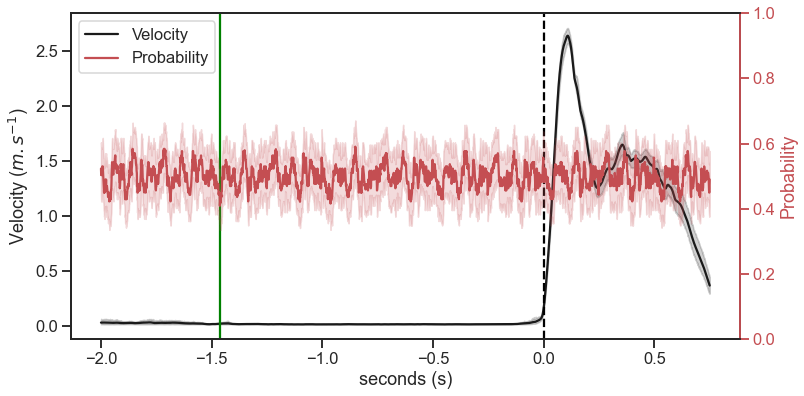

In [95]:
#figure(figsize=(12, 6))

# Velocity
#sns.set_theme(context='talk', style='ticks')
#ep_move = sns.lineplot(data=final_2, x='Time', y='Velocity', color='k', legend=False)

#ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
#plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
#plt.axvline(final_2['Time'][np.argmin(final_2.groupby(['Time'])['Probability'].mean())],
#            color='green', label = 'onset')

# Probability
#ax2 = plt.twinx()
#ax2.set_ylabel('Probability', color='r')
#ax2.spines['right'].set_color('r')
#ax2.tick_params(axis='y', colors='r')
#ep_prob = sns.lineplot(data=final_2, x='Time', y='Probability', ax=ax2, color='r', legend=False)
#plt.ylim((0,1))
# legend
#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="r", label='Probability')])

<font size="3" color='blue'>    <b>Load the EMG data</b>

In [14]:
pathemg = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\emg.csv'
emg = pd.read_csv(pathemg, header=None) # , dtype='float16'
emg.iloc[1,:] = emg.iloc[1,:] + 0.270
emg.iloc[0,:] = emg.iloc[0,:] - 0.009

<font size="3" color='red'>    <b>Extract the time frame of interest around the movement onset</b>

In [7]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='blue'>    <b>Same for EMG</b>

In [15]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
#actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

emepoch = np.zeros((len(onset), (b_onset + a_onset), emg.shape[0]))

for k in range(len(onset)):
   
    for j in range(emg.shape[0]):
    
        emepoch[k, 0:(b_onset + a_onset), j] = emg.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
        
#        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='red'>    <b>Baseline correction: I think this messes up the final result</b>

In [8]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3" color='red'>    <b>EEG Feature extraction</b>

In [9]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250             # 250 Here
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+(nb_feat)*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

<font size="3" color='blue'>    <b>Same for EMG</b>

In [16]:
# win_emg is actually = fs. What we will do is extracting the features once per window instead of 10 times like with EEG
# (j) Extract the feature once per channel
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
fs = 250
sld_size = 1

feat_emg = np.zeros((len(emepoch), df_emg.shape[1]-2, (emepoch.shape[1]//sld_size) - fs + sld_size))

for k in range(len(emepoch)):               # Onset index
    for l in range(feat_emg.shape[2]):      # Window index
        for j in range(emepoch.shape[2]):   # Channel index
            for i in range(len(feat_list)): # Feature index
                feat_emg[k, i+(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                    emepoch[k, (sld_size*l) : fs + (sld_size*l), j])

<font size="3" color='purple'>    <b>Merge for EEG_EMG</b>

In [21]:
feat_eeg_emg = np. concatenate((feat, feat_emg), axis=1)

<font size="3" color='red'>    <b>Probability extraction</b>

In [10]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][0]

<font size="3" color='blue'>    <b>Same for EMG</b>

In [17]:
proba_emg = np.zeros((feat_emg.shape[0], feat_emg.shape[2]))

for k in range(len(emepoch)):
    
    for l in range(feat_emg.shape[2]):
        
        proba_emg[k, l] = clf_emg.predict_proba(feat_emg[k, :, l].reshape(1, -1))[0][0]

<font size="3" color='purple'>    <b>Same for EEG_EMG</b>

In [22]:
proba_eeg_emg = np.zeros((feat_eeg_emg.shape[0], feat_eeg_emg.shape[2]))

for k in range(len(emepoch)):
    
    for l in range(feat_eeg_emg.shape[2]):
        
        proba_eeg_emg[k, l] = clf_eeg_emg.predict_proba(feat_eeg_emg[k, :, l].reshape(1, -1))[0][0]

In [48]:
clf_eeg_emg.predict_proba(feat_eeg_emg[5, :, 5].reshape(1, -1))

array([[0.18781567, 0.81218433]])

In [50]:
feat_eeg_emg[5, :, 5].shape

(210,)

<font size="3" color='red'>    <b>Final DataFrame and representation</b>

In [11]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity * 1000
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.007374,0.004127
1,-1.999,0.006945,0.005103
2,-1.998,0.006947,0.005929
3,-1.997,0.007485,0.006944
4,-1.996,0.007891,0.007865
...,...,...,...
409894,0.746,0.005464,0.176088
409895,0.747,0.007906,0.176456
409896,0.748,0.010623,0.168332
409897,0.749,0.013093,0.141768


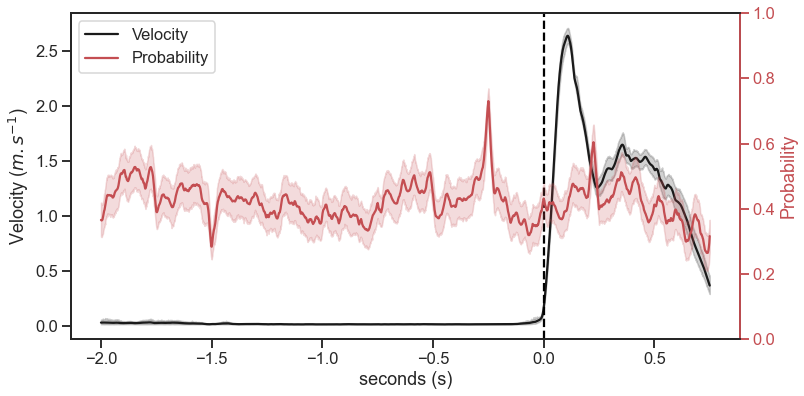

In [42]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
#plt.axvline(final['Time'][np.argmax(final.groupby(['Time'])['Probability'].mean())],
#            color='green', label = 'onset')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))
# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

In [358]:
final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())]

-0.125

<font size="3" color='blue'>    <b>Same for EMG</b>

In [18]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba_emg.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(emepoch))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_emg = np.reshape(proba_emg, len(f_time))

m_velocity = actual_velocity[:, :proba_emg.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data_emg = np.zeros((len(f_time), 3))
f_data_emg[:,0] = f_time
f_data_emg[:,1] = f_velocity * 1000
f_data_emg[:,2] = f_proba_emg
final_emg = pd.DataFrame(f_data_emg, columns=['Time', 'Velocity', 'Probability'])
final_emg

,Time,Velocity,Probability
0,-2.000,0.007374,0.346977
1,-1.999,0.006945,0.346957
2,-1.998,0.006947,0.346822
3,-1.997,0.007485,0.346794
4,-1.996,0.007891,0.346798
...,...,...,...
409894,0.746,0.005464,0.964879
409895,0.747,0.007906,0.964762
409896,0.748,0.010623,0.964607
409897,0.749,0.013093,0.964510


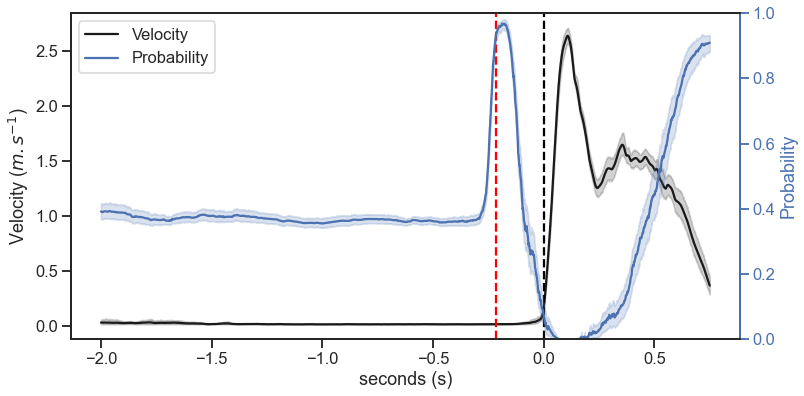

In [39]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
#plt.axvline(final_emg['Time'][np.argmin(final_emg.groupby(['Time'])['Probability'].mean())],
#            color='red', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(-0.216,
            color='red', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='Probability')])

<font size="3" color='purple'>    <b>Same for EEG_EMG</b>

In [23]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba_eeg_emg.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg_emg = np.reshape(proba_eeg_emg, len(f_time))

m_velocity = actual_velocity[:, :proba_eeg_emg.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data_eeg_emg = np.zeros((len(f_time), 3))
f_data_eeg_emg[:,0] = f_time
f_data_eeg_emg[:,1] = f_velocity * 1000
f_data_eeg_emg[:,2] = f_proba_eeg_emg
final_eeg_emg = pd.DataFrame(f_data_eeg_emg, columns=['Time', 'Velocity', 'Probability'])
final_eeg_emg

,Time,Velocity,Probability
0,-2.000,0.007374,0.001770
1,-1.999,0.006945,0.002259
2,-1.998,0.006947,0.002647
3,-1.997,0.007485,0.003113
4,-1.996,0.007891,0.003277
...,...,...,...
409894,0.746,0.005464,0.974259
409895,0.747,0.007906,0.979907
409896,0.748,0.010623,0.983437
409897,0.749,0.013093,0.983784


In [333]:
np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())

1789

In [334]:
final_eeg_emg['Time'][np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())]

-0.211

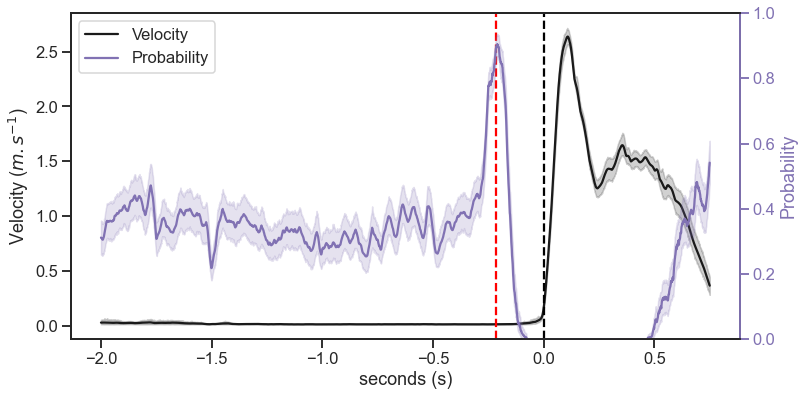

In [40]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
#plt.axvline(final_eeg_emg['Time'][np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())],
#            color='green', label = 'onset')
# Detection onset
plt.axvline(-0.216,
            color='red', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='m')
ax2.spines['right'].set_color('m')
ax2.tick_params(axis='y', colors='m')
ep_prob = sns.lineplot(data=final_eeg_emg, x='Time', y='Probability', ax=ax2, color='m', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='Probability')])

<font size="3" color='purple'>    <b>EEG and EMG superposition</b>

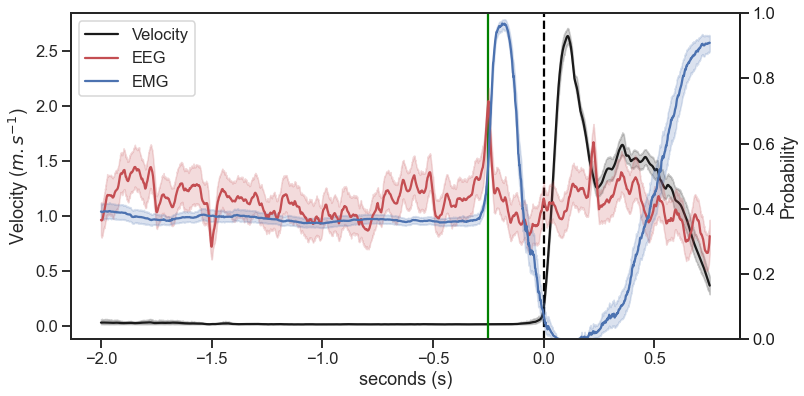

In [43]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(final['Time'][np.argmax(final.groupby(['Time'])['Probability'].mean())],
            color='green', label = 'onset')

# Probability EEG
ax2 = plt.twinx()
ax2.set_ylabel('Probability')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))

# Probability
ep_prob_2 = sns.lineplot(data=final_emg, x='Time', y='Probability',ax=ax2, color='b', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG'),
                                          Line2D([], [], marker='_', color="b", label='EMG')])

In [348]:
final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())]

-0.25

<font size="3" color='red'>    <b>Other option for baseline correction, after the feature extraction:</b>

In [ ]:
#Correct the baseline after mean feature extraction, I think it should work that way
cor = np.zeros((a.shape[0], a.shape[1]))
for k in range(a.shape[0]):
    for j in range(eeg_b.shape[0]):
        cor[k, nb_feat * j:nb_feat + nb_feat * j] = a[k, nb_feat * j:nb_feat + nb_feat * j] - \
                                                                    eeg_b.iloc[j, k * sld_size]

#Repeat the values to fit the number of time and velocity samples
cor_ext = np.repeat(cor, sld_size, axis=0)

In [25]:
filepath = 'eegloaded.pkl'
dill.dump_session(filepath) # Save the session

In [4]:
filepath = 'eegloaded.pkl'
dill.load_session(filepath)

Accélérer le script, faire la même pour EMG. Essayer de refaire la même chose avec intention intervale [-500ms - 0s]